INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.


Reporte de datos NaN por columna:
value    29717
dtype: int64


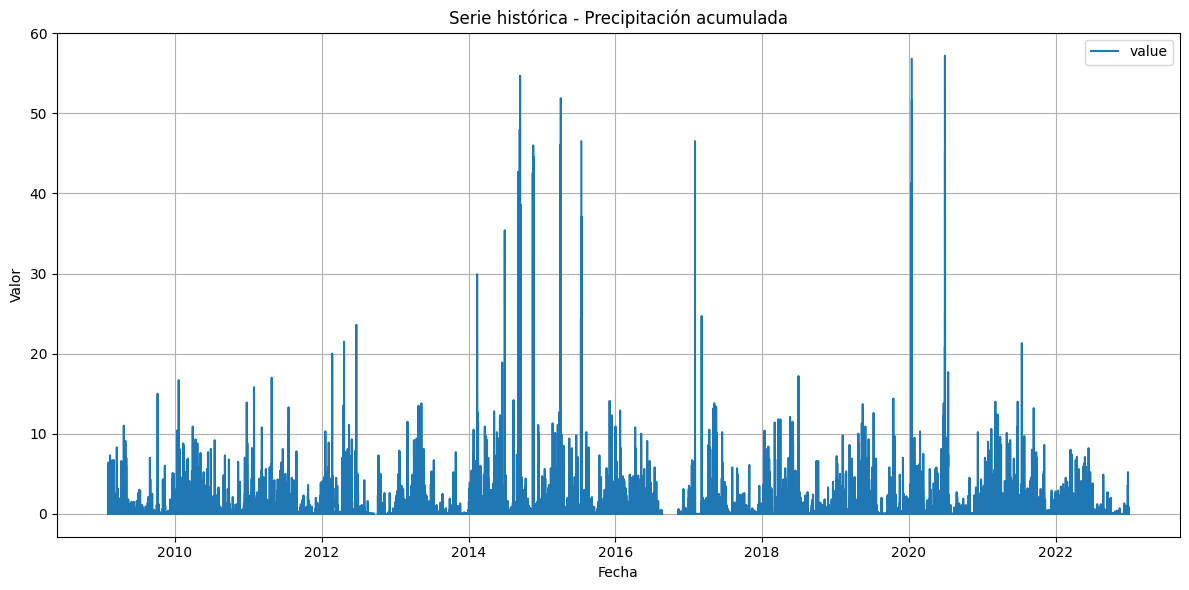

In [34]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    # Asegurar que el índice es datetime
    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    #logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(red_mpomm_serie, label=red_mpomm_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mostrar primeras filas
    red_mpomm_serie

Reporte de datos NaN y/o null en la serie actual: 
value    1845
dtype: int64 



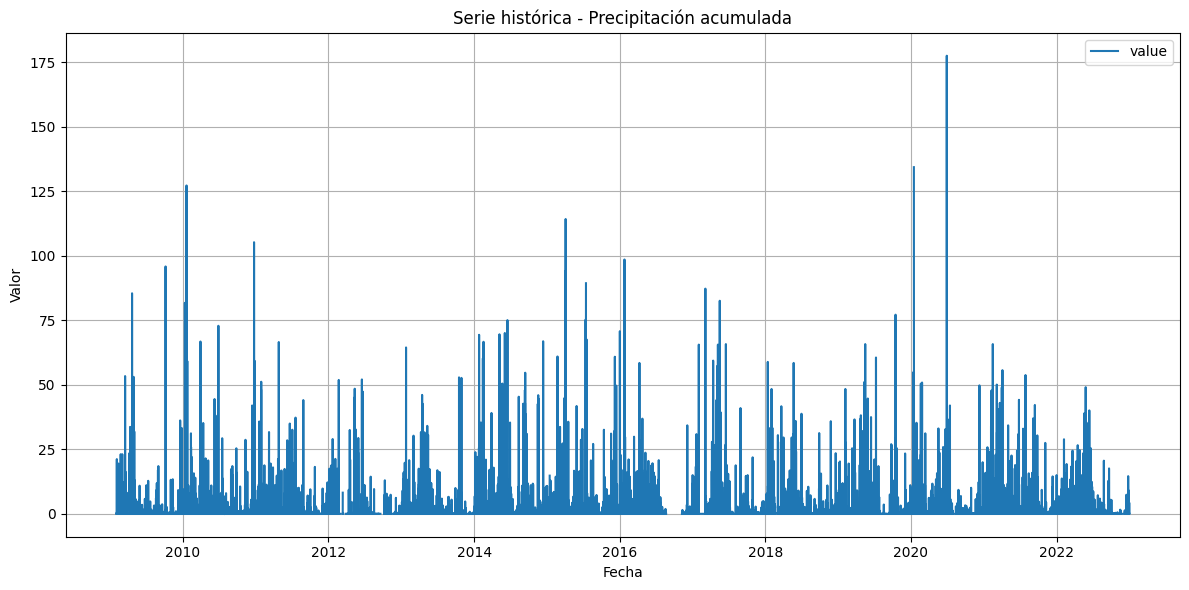

In [35]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
red_mpomm_serie_3h = red_mpomm_serie.resample('3h').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN y/o null en la serie actual: ')
print(red_mpomm_serie_3h.isnull().sum(),'\n')

# --- GRAFICAR ---
plt.figure(figsize=(12, 6))
plt.plot(red_mpomm_serie_3h, label=red_mpomm_serie_3h.columns[0])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie histórica - Precipitación acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

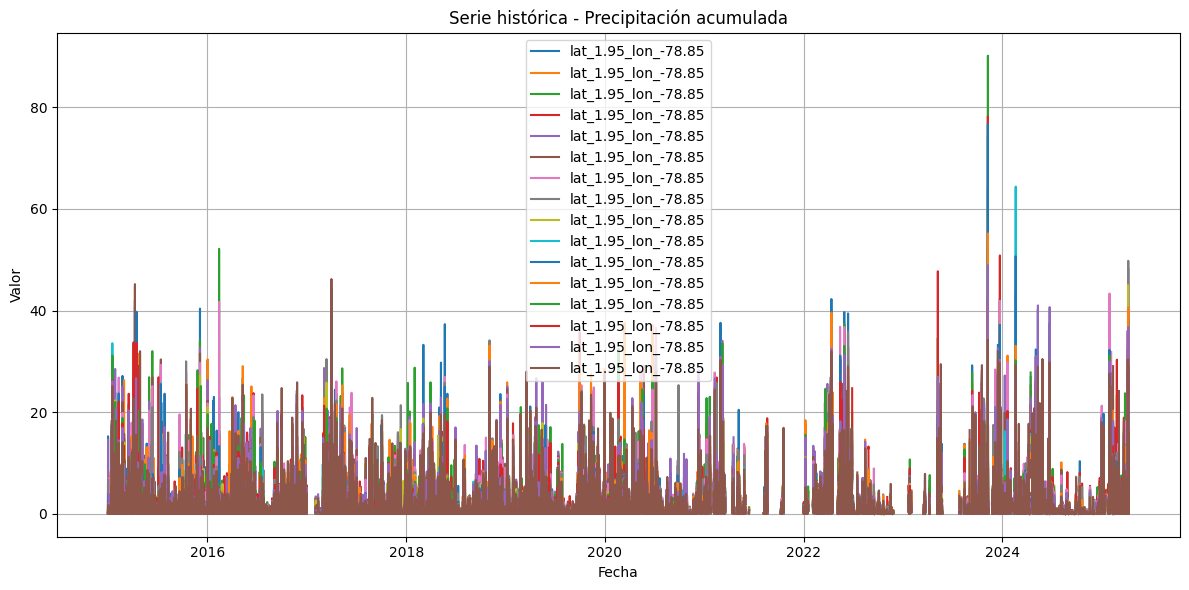

Reporte de datos NaN por columna:
lat_1.95_lon_-78.85    6392
lat_1.95_lon_-78.75    6392
lat_1.95_lon_-78.65    6392
lat_1.95_lon_-78.55    6392
lat_1.85_lon_-78.85    6392
lat_1.85_lon_-78.75    6392
lat_1.85_lon_-78.65    6392
lat_1.85_lon_-78.55    6392
lat_1.75_lon_-78.85    6392
lat_1.75_lon_-78.75    6392
lat_1.75_lon_-78.65    6392
lat_1.75_lon_-78.55    6392
lat_1.65_lon_-78.85    6392
lat_1.65_lon_-78.75    6392
lat_1.65_lon_-78.65    6392
lat_1.65_lon_-78.55    6392
dtype: int64


lat_1.95_lon_-78.85  lat_1.95_lon_-78.75  \
2015-01-01 00:00:00             0.125000             0.062500   
2015-01-01 03:00:00             0.625000             0.625000   
2015-01-01 06:00:00             0.812500             5.937500   
2015-01-01 09:00:00            15.250000             4.500000   
2015-01-01 12:00:00             0.125000             2.437500   
...                                  ...                  ...   
2025-04-10 03:00:00             2.341543             2.368103   
2025-04-10 06:00:00             1.648807             1.696712   
2025-04-10 09:00:00             2.502083             1.976913   
2025-04-10 12:00:00             1.961866             2.006043   
2025-04-10 15:00:00             4.365061             4.445565   

                     lat_1.95_lon_-78.65  lat_1.95_lon_-78.55  \
2015-01-01 00:00:00             0.062500             0.312500   
2015-01-01 03:00:00             0.562500             0.437500   
2015-01-01 06:00:00             4.375000             0.937500   
2015-01-01 09:00:00             5.750000             4.312500   
2015-01-01 12:00:00             3.437500             2.062500   
...                                  ...                  ...   
2025-04-10 03:00:00             2.450322             4.001059   
2025-04-10 06:00:00             1.721477             1.075704   
2025-04-10 09:00:00             2.050413             1.323445   
2025-04-10 12:00:00             2.080252             1.643980   
2025-04-10 15:00:00             4.403724             5.175233   

                     lat_1.85_lon_-78.85  lat_1.85_lon_-78.75  \
2015-01-01 00:00:00             0.125000             0.125000   
2015-01-01 03:00:00             0.562500             0.625000   
2015-01-01 06:00:00             1.062500             0.625000   
2015-01-01 09:00:00            14.625000             6.125000   
2015-01-01 12:00:00             0.437500             2.437500   
...                                  ...                  ...   
2025-04-10 03:00:00             3.961223             4.144755   
2025-04-10 06:00:00             1.983645             2.148014   
2025-04-10 09:00:00             2.197865             1.783330   
2025-04-10 12:00:00             1.231471             1.372182   
2025-04-10 15:00:00             7.493775             7.898080   

                     lat_1.85_lon_-78.65  lat_1.85_lon_-78.55  \
2015-01-01 00:00:00             0.062500             0.250000   
2015-01-01 03:00:00             0.500000             0.812500   
2015-01-01 06:00:00             6.187500             1.937500   
2015-01-01 09:00:00             4.562500             6.750000   
2015-01-01 12:00:00             2.250000             3.562500   
...                                  ...                  ...   
2025-04-10 03:00:00             4.344019             4.816211   
2025-04-10 06:00:00             2.185470             1.485247   
2025-04-10 09:00:00             1.831183             1.049082   
2025-04-10 12:00:00             1.387669             0.623440   
2025-04-10 15:00:00             7.921343             8.258113   

                     lat_1.75_lon_-78.85  lat_1.75_lon_-78.75  \
2015-01-01 00:00:00             0.062500             0.125000   
2015-01-01 03:00:00             0.500000             0.375000   
2015-01-01 06:00:00             0.375000             0.500000   
2015-01-01 09:00:00             2.312500             1.937500   
2015-01-01 12:00:00             0.875000             0.625000   
...                                  ...                  ...   
2025-04-10 03:00:00             3.467693             3.455798   
2025-04-10 06:00:00             1.677693             1.676899   
2025-04-10 09:00:00             1.374872             1.390130   
2025-04-10 12:00:00             1.017644             1.033707   
2025-04-10 15:00:00             6.013846             5.957229   

                     lat_1.75_lon_-78.65  lat_1.75_lon_-78.55  \
2015-01-01 00:00:00             0.062500           

In [36]:
# obtener datos de mswep
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
mswep_serie = pd.read_csv(
    r"E:\074-Diego Rengifo 2025\datasience\precipitacion\db\MSWEP-GloH2O\csv-3h\precipitacion radius(1.82011, -78.72871).csv",
    parse_dates=['dates'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='dates'        # establecer la columna como índice
)



# --- Preprocesamiento: Agregacion temporal ---
if not mswep_serie.empty:
    mswep_serie.index= pd.to_datetime(mswep_serie.index)

    # Paso 2: Crear una serie con índice completo con frecuencia cada 3 horas
    start = mswep_serie.index.min()
    end = mswep_serie.index.max()
    full_index = pd.date_range(start=start, end=end, freq='3h')

    # Paso 3: Reindexar para insertar NaN donde faltan datos
    mswep_serie_with_nans = mswep_serie.reindex(full_index)
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(mswep_serie_with_nans, label=mswep_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(mswep_serie_with_nans.isnull().sum())
mswep_serie_with_nans



In [37]:
# Crear dataset
from operator import index


serie_red = red_mpomm_serie_3h['value'].to_frame()
serie_red.index = pd.to_datetime(serie_red.index).tz_localize(None)
serie_mswep = mswep_serie_with_nans.copy()
serie_mswep.index = pd.to_datetime(serie_mswep.index).tz_localize(None)

# Hacer un left join para mantener todos los datos de red_mpomm_serie_3h
dataset = serie_red.join(serie_mswep, how="left")

# Asegurar que el índice no tiene zona horaria
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(dataset.isnull().sum())

# Mostrar primeras filas
dataset


Reporte de datos NaN por columna:
value                   1845
lat_1.95_lon_-78.85    20783
lat_1.95_lon_-78.75    20783
lat_1.95_lon_-78.65    20783
lat_1.95_lon_-78.55    20783
lat_1.85_lon_-78.85    20783
lat_1.85_lon_-78.75    20783
lat_1.85_lon_-78.65    20783
lat_1.85_lon_-78.55    20783
lat_1.75_lon_-78.85    20783
lat_1.75_lon_-78.75    20783
lat_1.75_lon_-78.65    20783
lat_1.75_lon_-78.55    20783
lat_1.65_lon_-78.85    20783
lat_1.65_lon_-78.75    20783
lat_1.65_lon_-78.65    20783
lat_1.65_lon_-78.55    20783
dtype: int64


value  lat_1.95_lon_-78.85  lat_1.95_lon_-78.75  \
timestamp                                                              
2009-02-01 03:00:00    0.0                  NaN                  NaN   
2009-02-01 06:00:00    0.0                  NaN                  NaN   
2009-02-01 09:00:00    0.0                  NaN                  NaN   
2009-02-01 12:00:00    0.0                  NaN                  NaN   
2009-02-01 15:00:00    0.0                  NaN                  NaN   
...                    ...                  ...                  ...   
2022-12-31 15:00:00    2.0                  NaN                  NaN   
2022-12-31 18:00:00    0.1                  NaN                  NaN   
2022-12-31 21:00:00    0.0                  NaN                  NaN   
2023-01-01 00:00:00    0.0                  NaN                  NaN   
2023-01-01 03:00:00    0.0                  NaN                  NaN   

                     lat_1.95_lon_-78.65  lat_1.95_lon_-78.55  \
timestamp                                                       
2009-02-01 03:00:00                  NaN                  NaN   
2009-02-01 06:00:00                  NaN                  NaN   
2009-02-01 09:00:00                  NaN                  NaN   
2009-02-01 12:00:00                  NaN                  NaN   
2009-02-01 15:00:00                  NaN                  NaN   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.85_lon_-78.85  lat_1.85_lon_-78.75  \
timestamp                                                       
2009-02-01 03:00:00                  NaN                  NaN   
2009-02-01 06:00:00                  NaN                  NaN   
2009-02-01 09:00:00                  NaN                  NaN   
2009-02-01 12:00:00                  NaN                  NaN   
2009-02-01 15:00:00                  NaN                  NaN   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.85_lon_-78.65  lat_1.85_lon_-78.55  \
timestamp                                                       
2009-02-01 03:00:00                  NaN                  NaN   
2009-02-01 06:00:00                  NaN                  NaN   
2009-02-01 09:00:00                  NaN                  NaN   
2009-02-01 12:00:00                  NaN                  NaN   
2009-02-01 15:00:00                  NaN                  NaN   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.75_lon_-78.85  lat_1.75_lon_-78.75  \
timestamp                                                       
2009-02-01 03:00:00                  NaN                  NaN   
2009-02-01 06:00:00                  NaN                  NaN   
2009-02-01 09:00:00                  NaN                  NaN   
2009-02-01 12:00:00                  NaN                  NaN   
2009-02-01 15:00:00                  NaN                  NaN   
...                                  ...                  ...   
2022-12-31 15:00:00       

In [38]:
# Encuentra el primer índice con dato no nulo en precipitation
start_index = dataset['lat_1.95_lon_-78.85'].first_valid_index()

# Filtra el DataFrame desde ese índice en adelante
filtered_dataset = dataset.loc[start_index:]

# Verifica resultado
print(f"Primer dato válido de precipitation: {start_index}")
filtered_dataset


Primer dato válido de precipitation: 2015-01-01 00:00:00


value  lat_1.95_lon_-78.85  lat_1.95_lon_-78.75  \
timestamp                                                              
2015-01-01 00:00:00    0.0               0.1250               0.0625   
2015-01-01 03:00:00    0.0               0.6250               0.6250   
2015-01-01 06:00:00    0.0               0.8125               5.9375   
2015-01-01 09:00:00    0.2              15.2500               4.5000   
2015-01-01 12:00:00    4.7               0.1250               2.4375   
...                    ...                  ...                  ...   
2022-12-31 15:00:00    2.0                  NaN                  NaN   
2022-12-31 18:00:00    0.1                  NaN                  NaN   
2022-12-31 21:00:00    0.0                  NaN                  NaN   
2023-01-01 00:00:00    0.0                  NaN                  NaN   
2023-01-01 03:00:00    0.0                  NaN                  NaN   

                     lat_1.95_lon_-78.65  lat_1.95_lon_-78.55  \
timestamp                                                       
2015-01-01 00:00:00               0.0625               0.3125   
2015-01-01 03:00:00               0.5625               0.4375   
2015-01-01 06:00:00               4.3750               0.9375   
2015-01-01 09:00:00               5.7500               4.3125   
2015-01-01 12:00:00               3.4375               2.0625   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.85_lon_-78.85  lat_1.85_lon_-78.75  \
timestamp                                                       
2015-01-01 00:00:00               0.1250               0.1250   
2015-01-01 03:00:00               0.5625               0.6250   
2015-01-01 06:00:00               1.0625               0.6250   
2015-01-01 09:00:00              14.6250               6.1250   
2015-01-01 12:00:00               0.4375               2.4375   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.85_lon_-78.65  lat_1.85_lon_-78.55  \
timestamp                                                       
2015-01-01 00:00:00               0.0625               0.2500   
2015-01-01 03:00:00               0.5000               0.8125   
2015-01-01 06:00:00               6.1875               1.9375   
2015-01-01 09:00:00               4.5625               6.7500   
2015-01-01 12:00:00               2.2500               3.5625   
...                                  ...                  ...   
2022-12-31 15:00:00                  NaN                  NaN   
2022-12-31 18:00:00                  NaN                  NaN   
2022-12-31 21:00:00                  NaN                  NaN   
2023-01-01 00:00:00                  NaN                  NaN   
2023-01-01 03:00:00                  NaN                  NaN   

                     lat_1.75_lon_-78.85  lat_1.75_lon_-78.75  \
timestamp                                                       
2015-01-01 00:00:00               0.0625               0.1250   
2015-01-01 03:00:00               0.5000               0.3750   
2015-01-01 06:00:00               0.3750               0.5000   
2015-01-01 09:00:00               2.3125               1.9375   
2015-01-01 12:00:00               0.8750               0.6250   
...                                  ...                  ...   
2022-12-31 15:00:00       

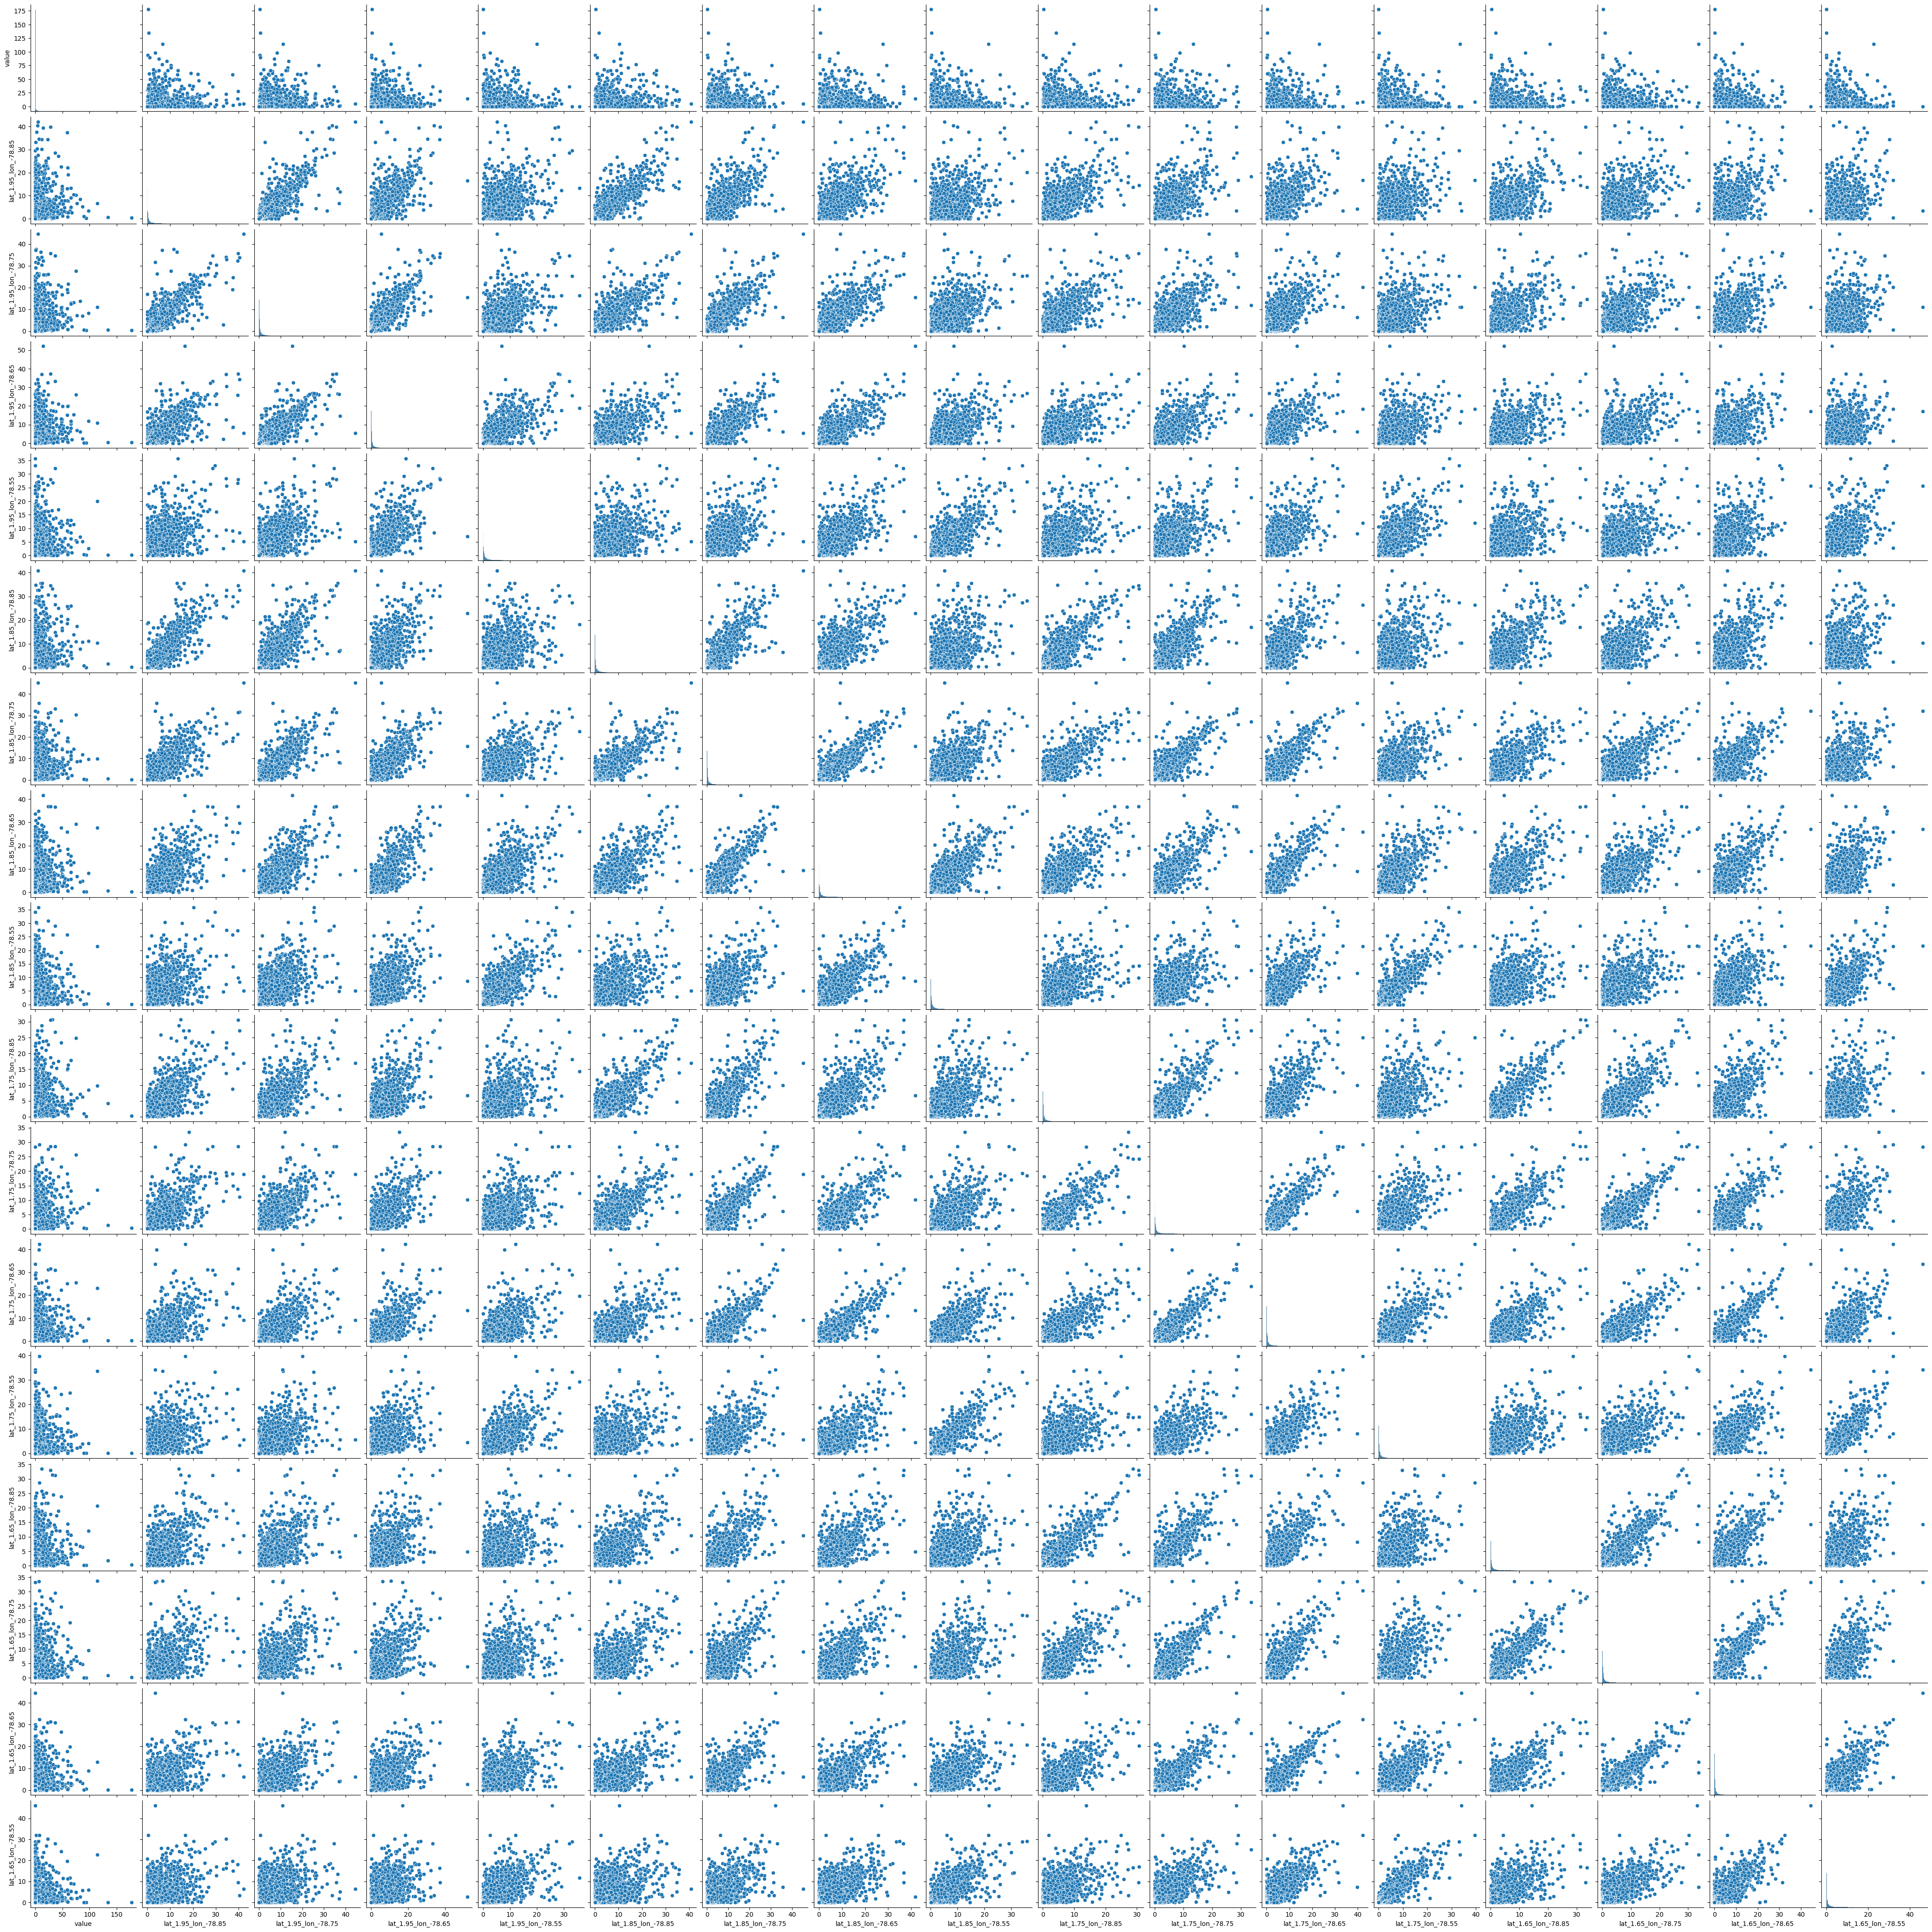

In [39]:
import seaborn as sns 
pair= sns.pairplot(filtered_dataset)

In [40]:
precipNotNan = filtered_dataset.dropna()
print('Reporte de datos NaN por columna:')
print(precipNotNan.isnull().sum())
precipNotNan

Reporte de datos NaN por columna:
value                  0
lat_1.95_lon_-78.85    0
lat_1.95_lon_-78.75    0
lat_1.95_lon_-78.65    0
lat_1.95_lon_-78.55    0
lat_1.85_lon_-78.85    0
lat_1.85_lon_-78.75    0
lat_1.85_lon_-78.65    0
lat_1.85_lon_-78.55    0
lat_1.75_lon_-78.85    0
lat_1.75_lon_-78.75    0
lat_1.75_lon_-78.65    0
lat_1.75_lon_-78.55    0
lat_1.65_lon_-78.85    0
lat_1.65_lon_-78.75    0
lat_1.65_lon_-78.65    0
lat_1.65_lon_-78.55    0
dtype: int64


value  lat_1.95_lon_-78.85  lat_1.95_lon_-78.75  \
timestamp                                                              
2015-01-01 00:00:00    0.0             0.125000             0.062500   
2015-01-01 03:00:00    0.0             0.625000             0.625000   
2015-01-01 06:00:00    0.0             0.812500             5.937500   
2015-01-01 09:00:00    0.2            15.250000             4.500000   
2015-01-01 12:00:00    4.7             0.125000             2.437500   
...                    ...                  ...                  ...   
2022-11-25 21:00:00    0.0             0.010713             0.010772   
2022-11-26 03:00:00    0.0             0.089401             0.091005   
2022-11-26 09:00:00    0.0             0.468541             0.485616   
2022-11-26 12:00:00    0.0             0.590147             0.613766   
2022-11-29 21:00:00    0.0             0.030078             0.014486   

                     lat_1.95_lon_-78.65  lat_1.95_lon_-78.55  \
timestamp                                                       
2015-01-01 00:00:00             0.062500             0.312500   
2015-01-01 03:00:00             0.562500             0.437500   
2015-01-01 06:00:00             4.375000             0.937500   
2015-01-01 09:00:00             5.750000             4.312500   
2015-01-01 12:00:00             3.437500             2.062500   
...                                  ...                  ...   
2022-11-25 21:00:00             0.010855             0.072824   
2022-11-26 03:00:00             0.091244             0.163856   
2022-11-26 09:00:00             0.481585             0.381236   
2022-11-26 12:00:00             0.612059             0.479617   
2022-11-29 21:00:00             0.001878             0.000005   

                     lat_1.85_lon_-78.85  lat_1.85_lon_-78.75  \
timestamp                                                       
2015-01-01 00:00:00             0.125000             0.125000   
2015-01-01 03:00:00             0.562500             0.625000   
2015-01-01 06:00:00             1.062500             0.625000   
2015-01-01 09:00:00            14.625000             6.125000   
2015-01-01 12:00:00             0.437500             2.437500   
...                                  ...                  ...   
2022-11-25 21:00:00             0.003150             0.003197   
2022-11-26 03:00:00             0.066818             0.071006   
2022-11-26 09:00:00             0.351868             0.389140   
2022-11-26 12:00:00             0.174324             0.191887   
2022-11-29 21:00:00             0.103373             0.345694   

                     lat_1.85_lon_-78.65  lat_1.85_lon_-78.55  \
timestamp                                                       
2015-01-01 00:00:00             0.062500             0.250000   
2015-01-01 03:00:00             0.500000             0.812500   
2015-01-01 06:00:00             6.187500             1.937500   
2015-01-01 09:00:00             4.562500             6.750000   
2015-01-01 12:00:00             2.250000             3.562500   
...                                  ...                  ...   
2022-11-25 21:00:00             0.003303             0.158481   
2022-11-26 03:00:00             0.072961             0.334455   
2022-11-26 09:00:00             0.395843             0.546286   
2022-11-26 12:00:00             0.197291             0.141774   
2022-11-29 21:00:00             0.041973             0.030042   

                     lat_1.75_lon_-78.85  lat_1.75_lon_-78.75  \
timestamp                                                       
2015-01-01 00:00:00             0.062500             0.125000   
2015-01-01 03:00:00             0.500000             0.375000   
2015-01-01 06:00:00             0.375000             0.500000   
2015-01-01 09:00:00             2.312500             1.937500   
2015-01-01 12:00:00             0.875000             0.625000   
...                                  ...                  ...   
2022-11-25 21:00:00       

In [41]:
# Correcto: usa el índice que corresponde con X e y
index = precipNotNan.index

# Aplica PCA después de haber alineado bien tus datos
X = precipNotNan.drop(columns='value')
y = precipNotNan['value']

from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ahora sí: divide incluyendo el índice correcto
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_pca, y, index, test_size=0.3, random_state=42
)
print(X_train.shape)
print(X_test.shape)


(13310, 2)
(5705, 2)


In [42]:
# Escala los datos de entrenamiento
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
xTrainScaled = scaler.transform(X_train)

# Escala también los datos de prueba
xTestScaled = scaler.transform(X_test)

In [43]:
from sklearn.neural_network import MLPRegressor

# Crea y entrena el modelo con los datos escalados
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='lbfgs',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    max_iter=10000,
    early_stopping=False,
    random_state=1
)

mlp.fit(xTrainScaled, y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,predict_test))
print(mlp.score(X_train,y_train))



-757.2239736546909
-854.0192074324541


In [44]:
# Predicción sobre los datos de prueba escalados
yPredict = mlp.predict(xTestScaled)
# Convertimos a serie con índice correcto para graficar
yPredict_series = pd.Series(yPredict, index=idx_test)

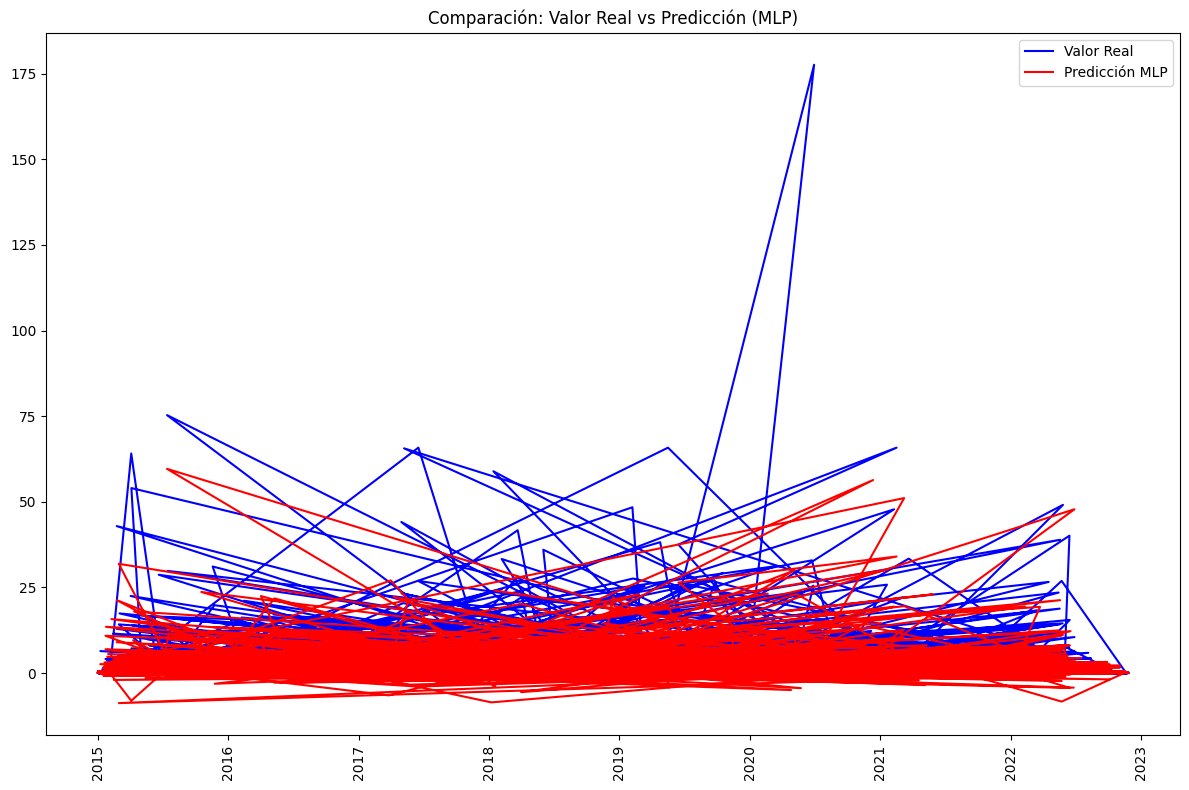

In [45]:
# Graficamos comparación
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8), sharex=True, sharey=True)
ax.plot(idx_test, y_test, label='Valor Real', color='blue')
ax.plot(idx_test, yPredict_series, label='Predicción MLP', color='red')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Comparación: Valor Real vs Predicción (MLP)')
plt.tight_layout()
plt.show()

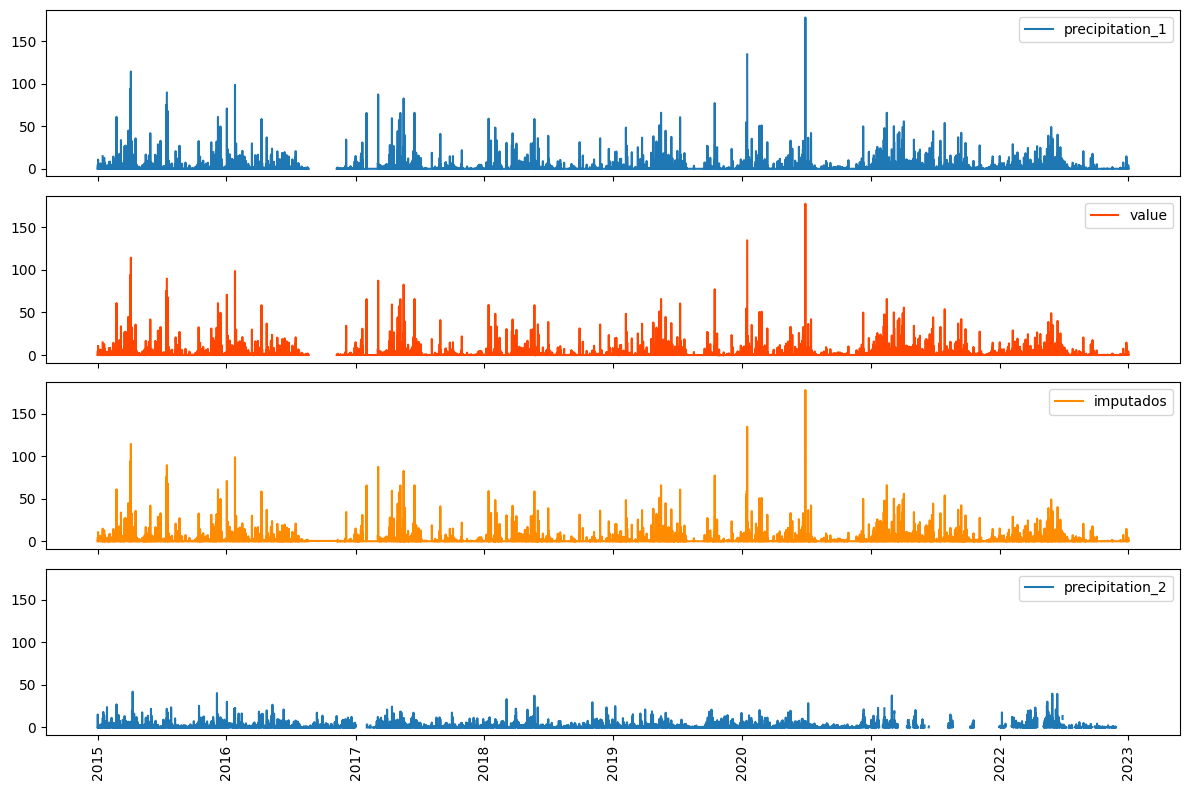

In [46]:
# Make sure it's a copy
filtered_dataset = filtered_dataset.copy()

# Create column with correct dtype
filtered_dataset['imputados'] = 0.0

# Fill imputados column
for index, row in filtered_dataset.iterrows():
    if np.isnan(row['value']) and ~np.isnan(row.iloc[1]) and ~np.isnan(row.iloc[2]):
        rowScaled = scaler.transform(X_train)
        prediction = mlp.predict(rowScaled)
        filtered_dataset.loc[index, 'imputados'] = max(prediction[0], 0.0)
    elif not np.isnan(row['value']):
        filtered_dataset.loc[index, 'imputados'] = row['value']
    else:
        filtered_dataset.loc[index, 'imputados'] = np.nan


# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True, sharey=True)

axs[0].plot(filtered_dataset.index, filtered_dataset.iloc[:, 0], label='precipitation_1')
axs[0].legend()

axs[1].plot(filtered_dataset.index, filtered_dataset['value'], label='value', color='orangered')
axs[1].legend()

axs[2].plot(filtered_dataset.index, filtered_dataset['imputados'], label='imputados', color='darkorange')
axs[2].legend()

axs[3].plot(filtered_dataset.index, filtered_dataset.iloc[:, 1], label='precipitation_2')
axs[3].legend()

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


In [47]:
from graphics_utils.go import multi_line

fig=multi_line(original=filtered_dataset['value'], imputada=filtered_dataset['imputados'])
fig.show()